In [1]:
import sys
import os
import numpy as np
import pandas as pd
sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath('"Top 10 Funds by AUM Positioning - Data Gen.ipynb"')))))
sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath('"Top 10 Funds by AUM Positioning - Data Gen.ipynb"')))))
import apis.qe.myqengine as qe

Python-dotenv could not parse statement starting at line 5


In [2]:
time_series = qe.TimeSeries(start_date = '-23M',end_date = '0M', frequency='M',calendar='NAY')

univ = qe.IdUniverse(ids = ['AAPL-US','META-US','AMZN-US','NVDA-US','GOOGL-US','MSFT-US','TSLA-US'],universe_type='Equity')
req = qe.calculate(universe = univ, dates = time_series,formulas = ["FE_BROKER_ESTIMATE(SNAP,EPS,BKR_NAME,ANN_ROLL,+1,#DATE,,',AWIN=1D,ESTDATE=INPUT,WIN=31,')",
                                            "FE_BROKER_ESTIMATE(SNAP,EPS,AN_NAME,ANN,+1,#DATE,,'WIN=31,AWIN=1D,ESTDATE=INPUT,')",
                                           "FE_BROKER_ESTIMATE(SNAP,EPS,EST_VALUE,ANN,+1,#DATE,,'WIN=31,AWIN=1D,ESTDATE=INPUT')",
                                           "FE_BROKER_ESTIMATE(SNAP,EPS,PREV_VALUE,ANN,+1,#DATE,,'WIN=31,AWIN=1D,ESTDATE=INPUT')",
                                        "FE_BROKER_ESTIMATE_DATE(SNAP,EPS,INPUTDATETIME,ANN,+1,'YYYYMMDD',#DATE,,'AWIN=1D,ESTDATE=INPUT,WIN=31')",
                                        "FE_BROKER_ESTIMATE(SNAP,EPS,AN_ENTITY_ID,ANN,+1,#DATE,,',AWIN=1D,ESTDATE=INPUT,WIN=31,')",
                                        "FE_ESTIMATE_DATE(RPT_DATE,,QTR_ROLL,+1,'YYYYMMDD',#DATE,,,'')",
                                        "FE_SURPRISE(PERCENT,EPS,MEAN,QTR_ROLL,0,#DATE,,,'')",
                                        "P_PRICE_RETURNS(1,20220831,#DATE,RANGE,USD)"],
                                        source = 'FqlExpression',
                                        is_array_return_type=True)


In [3]:
df = req.data.rename(columns={'UNIVERSE':"Ticker"}).set_index("Ticker")
df= df.rename(columns = {"FE_BROKER_ESTIMATE(SNAP,EPS,BKR_NAME,ANN_ROLL,+1,#DATE,,',AWIN=1D,ESTDATE=INPUT,WIN=31,')":"Broker Name",
                     "FE_BROKER_ESTIMATE(SNAP,EPS,AN_NAME,ANN,+1,#DATE,,'WIN=31,AWIN=1D,ESTDATE=INPUT,')":'Analyst Name',
                    "FE_BROKER_ESTIMATE(SNAP,EPS,EST_VALUE,ANN,+1,#DATE,,'WIN=31,AWIN=1D,ESTDATE=INPUT')":"EST_EPS_FY1",
                    "FE_BROKER_ESTIMATE(SNAP,EPS,PREV_VALUE,ANN,+1,#DATE,,'WIN=31,AWIN=1D,ESTDATE=INPUT')":"PREV_EST_EPS_FY1",
                    "FE_BROKER_ESTIMATE_DATE(SNAP,EPS,INPUTDATETIME,ANN,+1,'YYYYMMDD',#DATE,,'AWIN=1D,ESTDATE=INPUT,WIN=31')":'Research Date',
                    "FE_BROKER_ESTIMATE(SNAP,EPS,AN_ENTITY_ID,ANN,+1,#DATE,,',AWIN=1D,ESTDATE=INPUT,WIN=31,')":"Analyst ID",
                    "P_PRICE_RETURNS(1,20220831,#DATE,RANGE,USD)":"Cumulative Return",
                    "FE_ESTIMATE_DATE(RPT_DATE,,QTR_ROLL,+1,'YYYYMMDD',#DATE,,,'')":'Report Date',
                    "FE_SURPRISE(PERCENT,EPS,MEAN,QTR_ROLL,0,#DATE,,,'')":"Surprise",
                    "DATE":'Date'
                    })

df['Date'] = pd.to_datetime(df['Date']).apply(lambda x:x.strftime("%m/%d/%Y"))
df['Cumulative Return']= df['Cumulative Return'].apply(lambda x:x[0])
df['Report Date']= pd.to_datetime(df['Report Date'].apply(lambda x: x[0]))
df['Surprise']= df['Surprise'].apply(lambda x: x[0]).astype(float)
df_aapl = pd.concat([df['Analyst ID'].explode().reset_index()[['Ticker','Analyst ID']],df['Broker Name'].explode().reset_index().iloc[:,-1:],df['Analyst Name'].explode().reset_index().iloc[:,-1:],df['EST_EPS_FY1'].explode().reset_index().iloc[:,-1:],df['PREV_EST_EPS_FY1'].explode().reset_index().iloc[:,-1:],df['Research Date'].explode().reset_index().iloc[:,-1:]],axis=1)
df_aapl['Research Date'] = pd.to_datetime(df_aapl['Research Date'])
df_aapl = df_aapl.replace('Restricted',np.nan).replace('@NA',np.nan)
df_aapl = df_aapl.groupby(['Research Date','Broker Name','Ticker']).agg({'EST_EPS_FY1':'mean'})

df_aapl.head()

EST_EPS_FY1
Research Date Broker Name            Ticker              
2021-09-07    Monness, Crespi, Hardt TSLA-US        1.940
2021-09-08    Cowen & Company        AAPL-US        6.010
2021-09-09    Arete Research LLP     AMZN-US        3.394
              BNP Paribas Exane      META-US       18.590
              JP Morgan              MSFT-US       12.950

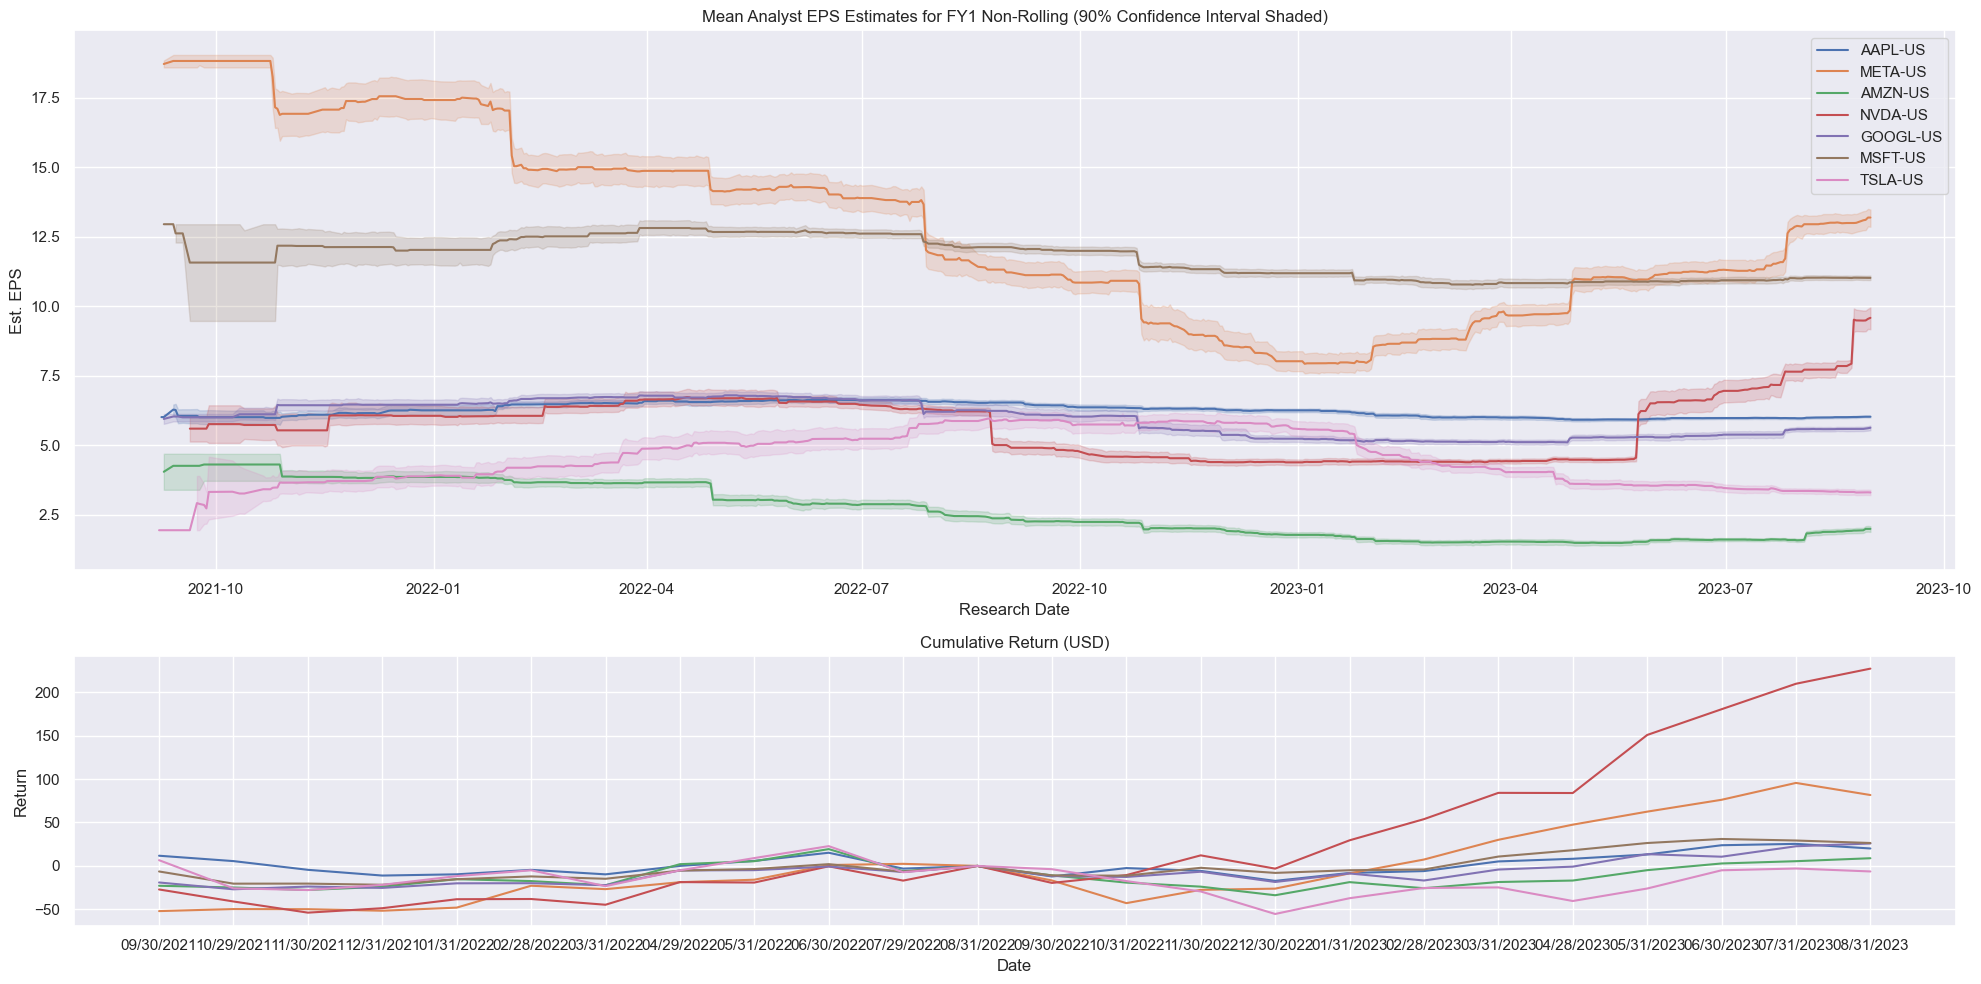

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
fig,axs = plt.subplots(2,1,figsize=(20,10),gridspec_kw={'height_ratios': [2, 1]})

sns.lineplot(df_aapl['EST_EPS_FY1'].unstack().unstack().ffill(limit = 90).stack().stack().rename('EST_EPS_FY1').reset_index(),
                x = 'Research Date',y = 'EST_EPS_FY1',hue = 'Ticker',ax=axs[0],hue_order = list(df.index.unique()))
axs[0].set_title('Mean Analyst EPS Estimates for FY1 Non-Rolling (90% Confidence Interval Shaded)')
axs[0].set_ylabel('Est. EPS')
axs[0].legend(loc='upper right')

sns.lineplot(df.reset_index(),
                x = 'Date',y = 'Cumulative Return',hue = 'Ticker',ax=axs[1],hue_order = list(df.index.unique()))
axs[1].set_title('Cumulative Return (USD)')
axs[1].set_ylabel('Return')
axs[1].get_legend().remove()

plt.savefig('magnificant_7_FYE1_Broker_EPS_Estimates.png', format='png', dpi=100)

plt.tight_layout()

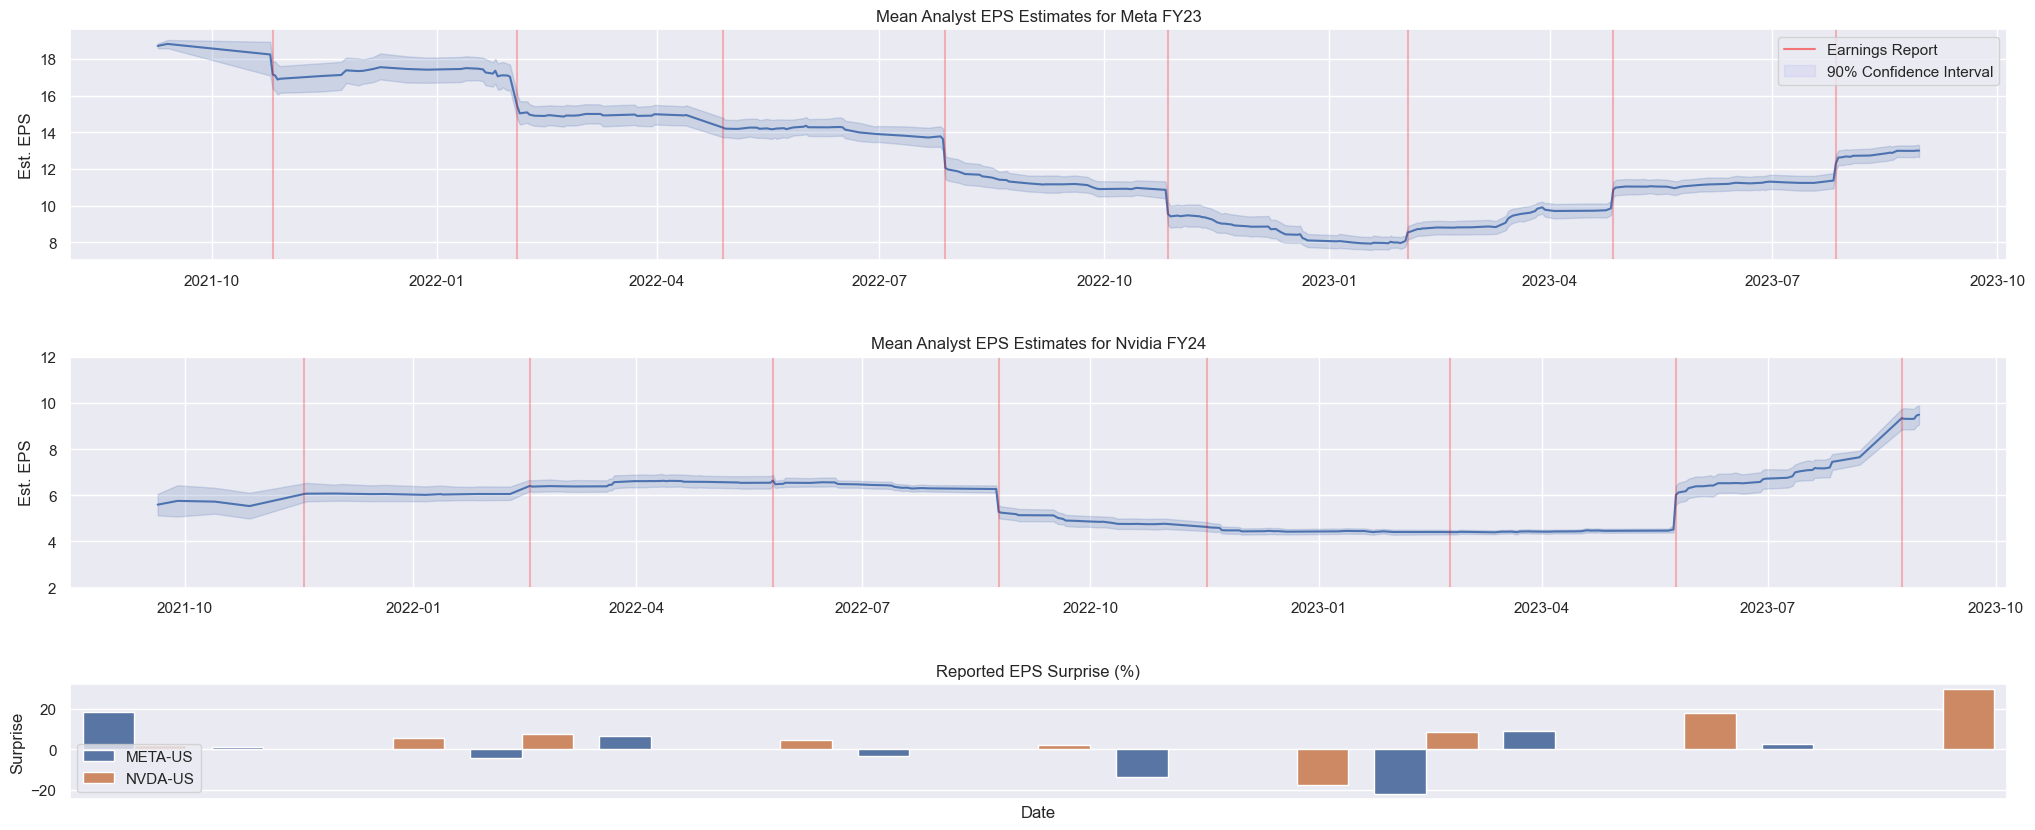

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.dates as mdates
sns.set_theme(style="darkgrid")
fig,axs = plt.subplots(3,1,figsize=(25,10),gridspec_kw={'height_ratios': [2,2, 1]})
# Create a patch for the 90% confidence interval
confidence_patch = mpatches.Patch(color='blue', label='90% Confidence Interval',alpha =.05)

# Create a line for the Quarterly Report
line = mlines.Line2D([], [], color='red', label='Earnings Report',alpha = .5)


df_mn = df_aapl.reset_index()[df_aapl.reset_index()['Ticker'].isin(['META-US'])].set_index(['Research Date','Broker Name','Ticker'])
sns.lineplot(data=df_mn['EST_EPS_FY1'].unstack().unstack().ffill(limit = 45).stack().stack().rename('EST_EPS_FY1').reset_index(), x='Research Date', y='EST_EPS_FY1',hue='Ticker', ax=axs[0])

for report_date in list(df.xs('META-US')['Report Date'].unique())[:-1]:
    axs[0].axvline(report_date, color = 'red', label = 'Quarterly Report',alpha = .25)
axs[0].set_xlabel('')
axs[0].set_title('Mean Analyst EPS Estimates for Meta FY23')
axs[0].get_legend().remove()
axs[0].set_ylabel('Est. EPS')
axs[0].legend(handles=[line, confidence_patch])
#sns.barplot(df_n.iloc[:,1].reset_index(),ax=axs[0],x='Date',y='NVDA-US')
df_mn = df_aapl.reset_index()[df_aapl.reset_index()['Ticker'].isin(['NVDA-US'])].set_index(['Research Date','Broker Name','Ticker'])
sns.lineplot(data=df_mn['EST_EPS_FY1'].unstack().unstack().ffill(limit = 45).stack().stack().rename('EST_EPS_FY1').reset_index(), x='Research Date', y='EST_EPS_FY1', hue='Ticker', ax=axs[1])

for report_date in list(df.xs('NVDA-US')['Report Date'].unique())[:-1]:
    axs[1].axvline(report_date, color = 'red', label = 'Quarterly Report',alpha = .25)
axs[1].set_xlabel('')
axs[1].set_ylim((2,12))
axs[1].set_title('Mean Analyst EPS Estimates for Nvidia FY24')
axs[1].get_legend().remove()
axs[1].set_ylabel('Est. EPS')

df_temp = df.reset_index()
df_temp = df_temp[df_temp['Ticker'].isin(['META-US','NVDA-US'])]
sns.barplot(data=df_temp[['Ticker','Surprise','Date']].drop_duplicates('Surprise'),x='Date',y='Surprise',hue='Ticker',ax=axs[2])
locator = mdates.MonthLocator()  # every month
axs[2].xaxis.set_major_locator(locator)
fmt = mdates.DateFormatter('%b')
axs[2].xaxis.set_major_formatter(fmt)
axs[2].set_title('Reported EPS Surprise (%)')
axs[2].set_xticks([])
axs[2].legend(loc='lower left')
plt.subplots_adjust(hspace = 0.5)
plt.savefig('META_NVIDIA_WITH_SURPRISE.png', format='png', dpi=100)

plt.show()
